## **[Introduction to Forecasting Ensembles](https://towardsdatascience.com/introduction-to-forecasting-ensembles-f63877a2498)**
#### **A cheap trick to boost forecasting performance**

If you need to squeeze in an extra bit of performance, a forecast combination might be what you’re looking for.

Forecast combination is the process of combining the predictions of many models. This technique is also known as ensemble forecasting.

Here, you’ll learn the 3 main steps of creating an ensemble for forecasting.

### **Why Use an Ensemble?**
No forecasting method is perfect.

There are several techniques for creating forecasting models. Examples include classical approaches such as ARIMA or exponential smoothing. Or machine learning methods, such as decision trees or neural networks. You can check my previous article on how to do supervised learning with time series.

Each approach has its own assumptions about the data, which do not always hold. Every method has its strengths and limitations. Managing these two is a key motivation for ensembles.

Combining several models can often lead to more accurate predictions. One reason for this is that it reduces the chance of picking the wrong model.

Besides, an ensemble can be useful to convey the uncertainty of future observations. High forecast variability among the models suggests greater uncertainty. This aspect is valuable for decision-making.

So, how do ensembles work?

#### **3 Stages of Building an Ensemble**
Building an ensemble is a 3-stage process:

- Creation: building different individual models;
- Pruning: removing poor or redundant models;
- Integration: combining the models.


<center> <p>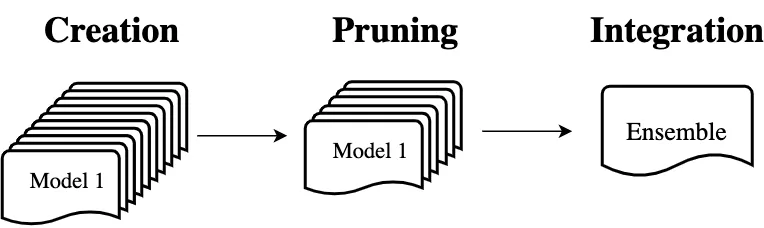</p> </center>

Let’s dive a bit deeper into each step.

#### **Creation Step**

The first step is to create the models that constitute the ensemble.

Diversity among the models is a key thing you should mind. Each model should provide good but different predictions from the others. Highly correlated models reduce the effectiveness of the ensemble.

So, how do you foster diversity when building ensembles? There are two main strategies to do that:

1 .Changing the learning method or its parameters;
2. Manipulating the training data.

Different methods hold different assumptions about the data. So, this leads to a natural diversity within the ensemble.

An ensemble is called heterogeneous if its models are trained using different algorithms. For example linear models and decision trees. Otherwise, the ensemble is called homogeneous. `Random Forests are an example of a homogeneous ensemble of decision trees.`

How is diversity encouraged in homogeneous ensembles like Random Forests?

The input data for Random Forests is manipulated in two ways:

- The training data for each tree is sampled with replacement. This process is known as bagging;
- Within each tree, a random subset of the features is selected at each split. This further increases diversity.

The article in reference [3] provides an excellent review of diversity in ensembles.



#### **Pruning Step**

Many models are built during the creation step.

There’s a bit of randomness to this process. But, there’s no guarantee that all models will be useful or improve diversity.

A way to remedy this issue is to prune the ensemble. This involves removing unwanted models. A model should be discarded because of its poor performance or because it is redundant.

After removing unwanted models you get a better ensemble. One with better forecasting performance and fewer models to maintain.

#### **Integration Step**
The final stage is integration. This is when you combine the predictions of the individual models.

The simplest approach to do this is by taking the average of the predictions. Or, in the case of classification, by majority voting. An alternative is to assign different weights to each model and take a weighted average. One way to determine the weights is based on past performance. If a model has performed well, you give it a higher weight.

#### **Hands-On**
Let’s build a forecasting ensemble using Python.

Here’s the code, which is explained in the comments:

In [ ]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from pmdarima.datasets import load_ausbeer  # GPL>=2 licence

from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    AutoTheta,
    AutoETS,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

from src.plots.forecasts import train_test_yhat_plot
from src.plots.barplots import err_barplot

# quarterly data
PERIOD = 4
# forecasting the final 3 years of data
TEST_SIZE = 12

# loading the beer time series
series = load_ausbeer(as_series=True).dropna()
series.index = pd.date_range(start='1956Q1', end='2008Q3', freq='QS')

# train/test split
train, test = train_test_split(series, test_size=TEST_SIZE, shuffle=False)

# transforming the train data to the required format for statsforecast
train_df = train.reset_index()
train_df.columns = ['ds', 'y']
train_df['unique_id'] = '1'

# setting up the models
models = [
    AutoARIMA(season_length=PERIOD),
    HoltWinters(season_length=PERIOD),
    SeasonalNaive(season_length=PERIOD),
    AutoTheta(season_length=PERIOD),
    DOT(season_length=PERIOD),
    AutoETS(season_length=PERIOD),
]

sf = StatsForecast(
    df=train_df,
    models=models,
    freq='Q',
    n_jobs=1,
    fallback_model=SeasonalNaive(season_length=PERIOD)
)

# training the models
sf.fit(train_df)

# forecasting
forecasts = sf.predict(h=TEST_SIZE)
forecasts = forecasts.reset_index(drop=True).set_index('ds')

# averaging the forecasts to make the ensemble predictions
forecasts['Ensemble'] = forecasts.mean(axis=1)

As a case study, the goal is to forecast the production of beer. You can check the source of this data in reference [3]. We created 6 forecasting models using the `statsforecast` library. These include AutoARIMA, Holt-Winters, or AutoETS.

Then, the forecasts of the 6 models are averaged to form the ensemble forecasts.

Here’re the forecasts:

<center> <p>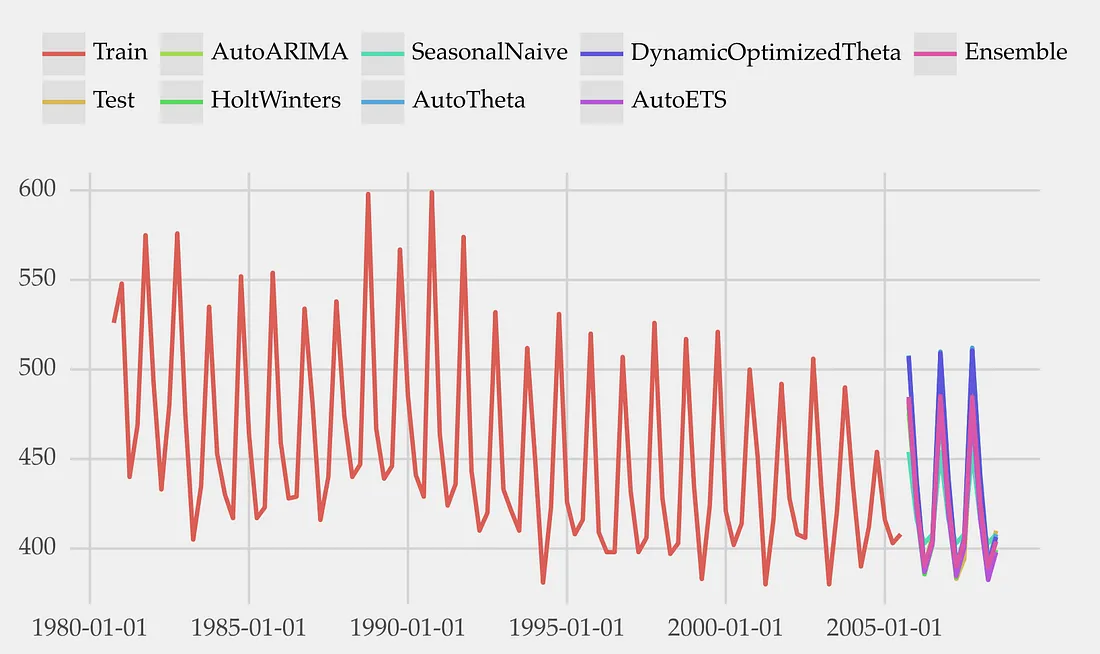</p> </center>

Now, here’s the mean absolute error of each approach:

<center> <p>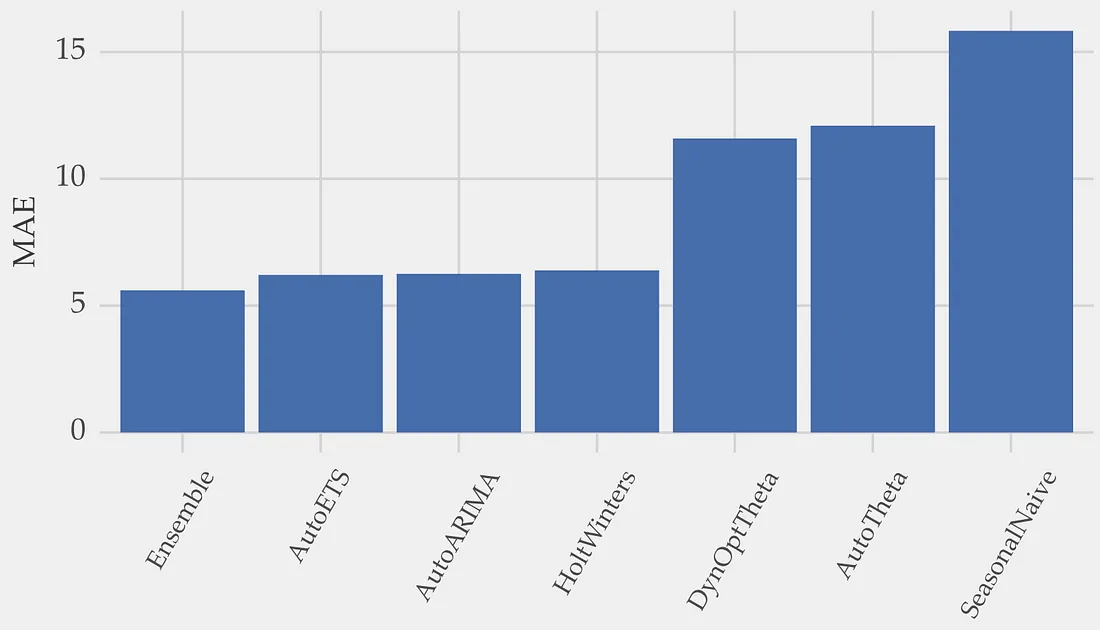</p> </center>

The ensemble is able to perform better than any individual model.

In this example, the ensemble contains only 6 models. But, ensembles often have many more models (up to hundreds). Still, there’s a diminishing returns effect as more models are added.

#### **What’s the catch?**
While ensembles improve forecasting performance they have a few limitations.

1. You have to maintain several models instead of one. This leads to extra computational costs. For example, if you need to deploy the models in small devices there may not be enough storage space. If the data is sampled with a high frequency, the time to get and combine all forecasts may be too high.
2. Ensembles lack transparency. In some domains, transparent models are essential for trustworthiness and adoption by practitioners.

#### **Take-Aways**

- Ensembles combine the predictions of several models. This often leads to better forecasting performance;
- Ensembles are built in 3 stages: creation, pruning, and integration;
- The main limitations of ensembles are the extra computational costs and lack of transparency.

Thanks for reading, and see you in the next story!


#### **References**
[1] Aiolfi, Marco, and Allan Timmermann. “Persistence in forecasting performance and conditional combination strategies.” Journal of Econometrics 135.1–2 (2006): 31–53.

[2] Brown, Gavin, et al. “Diversity creation methods: a survey and categorisation.” Information fusion 6.1 (2005): 5–20.

[3] Quarterly Australian Beer production (GPL ≥ 2 licence) https://www.rdocumentation.org/packages/fpp/versions/0.5/topics/ausbeer